# 1- Environment set-up

In [115]:
%cd /content/drive/MyDrive/Projects/ML_Labs/

/content/drive/MyDrive/Projects/ML_Labs


Update the path to import from drive

In [116]:
!pip install yfinance
!pip install -U scikit-learn==0.24.2 #update to version 0.24.2
!pip install ta

Requirement already up-to-date: scikit-learn==0.24.2 in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [117]:
!cp ./get_data_yf.py .
!cp ./backtest.py .

cp: './get_data_yf.py' and './get_data_yf.py' are the same file
cp: './backtest.py' and './backtest.py' are the same file


Import modules and the get_data_yf file. **Not that the references to the backtest module and the Strategy class have been removed for compatibility.**

In [118]:
import get_data_yf
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import sklearn.feature_selection as fs
from datetime import date
from dateutil.relativedelta import relativedelta
import plotly.express as px
import ta

We import the market pricing data for the last four years, so we can compute indicators like the moving average for an extensive dataset.

In [119]:
entity = '^GSPC'    # S&P500's symbol
#t1 = 5              # FROM t1 years ago (start date)
m1 = 48              # FROM m1 months ago (start date)
#t2 = 1             # TO t2 years ago (end date)
start = (date.today()+relativedelta(months=-m1)).strftime("%Y-%m-%d")    # 'yyyy-mm-dd' format
end = time.strftime("%Y-%m-%d")     # today
#end = (date.today()+relativedelta(years=-t2)).strftime("%Y-%m-%d")

get_it = get_data_yf.Get_data(entity, start, end)
candles = get_it.get_raw_prices()
candles.to_csv('S&P500.csv') #Save the data as csv for later use with backtrader
candles.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [120]:
candles.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1001,2021-06-08,4233.810059,4236.740234,4208.410156,4227.259766,4227.259766,3943870000
1002,2021-06-09,4232.990234,4237.089844,4218.740234,4219.549805,4219.549805,3902870000
1003,2021-06-10,4228.560059,4249.740234,4220.339844,4239.180176,4239.180176,3502480000
1004,2021-06-11,4242.899902,4248.379883,4232.250000,4247.439941,4247.439941,3204280000
1005,2021-06-14,4248.310059,4255.589844,4234.069824,4255.149902,4255.149902,3612050000


# 2- Developing and selecting technical indicators

We create a dataframe of indicators the engineer the features for the model.

In [121]:
indicators = pd.DataFrame()

## 2.1- Target variables

The target of the model is to predict the direction of the future movement of the market. One straight way of codifying this behaviour is to assignate a value to whether the product price has increased (1), decreased (-1) or keep relatively constant (0) after 1 day and 1 week.

**The threshold for wheter to understand the price significantly moving or staying neutral will be placed at a $\pm$0.1% of the value of the initial day.** 

This is a relevant choice, that could be tunned in the feature (for example, demanding the price variation to be of higher magnitude to be understood as non-neutral, hence training the model to detect only the most significant trends).

On top of the direction of the evolution we generate as well the magnitude of this variation by difference.

In [122]:
def price_evolution(prices:pd.Series)->int:
  #Since we apply this function with a rolling window, the input is a pnadas Serie
  initial_value = prices.iloc[0]
  final_value = prices.iloc[-1]
  #
  if final_value > initial_value*1.001:
    return 1
  elif final_value < initial_value*0.999:
    return -1
  else:
    return 0

In [123]:
def price_difference(prices:pd.Series)->int:
  #Since we apply this function with a rolling window, the input is a pnadas Serie
  initial_value = prices.iloc[0]
  final_value = prices.iloc[-1]
  return final_value-initial_value

Applying the price evolution function with different windows we can generate some target variables:
* Price direction after one day
* Price direction after one week
* Price difference after one day
* Price difference after one week

In [124]:
#Creating forward windows is not straight-forward in pandas, and in the DOc is done by applying the function below:
week_window = pd.api.indexers.FixedForwardWindowIndexer(window_size=6)
day_window = pd.api.indexers.FixedForwardWindowIndexer(window_size=2)

indicators['Date']=candles['Date']
indicators['Week_evolution'] = candles['Close'].rolling(window=week_window).apply(price_evolution)
indicators['Day_evolution'] = candles['Close'].rolling(window=day_window).apply(price_evolution)
indicators['Week_difference'] = candles['Close'].rolling(window=week_window).apply(price_difference)
indicators['Day_difference'] = candles['Close'].rolling(window=day_window).apply(price_difference)

In [125]:
indicators['Close'] = candles['Close']

Now we have a pair of columns for the direction of the price variation as well as the magnitude by difference.

In [126]:
indicators.head(5)

,Date,Week_evolution,Day_evolution,Week_difference,Day_difference,Close
0,2017-06-15,0.0,0.0,2.040039,0.689941,2432.459961
1,2017-06-16,1.0,1.0,5.150146,20.310059,2433.149902
2,2017-06-19,-1.0,-1.0,-14.389893,-16.429932,2453.459961
3,2017-06-20,-1.0,0.0,-17.650146,-1.419922,2437.030029
4,2017-06-21,1.0,0.0,5.079834,-1.110107,2435.610107


In [127]:
import seaborn as sns

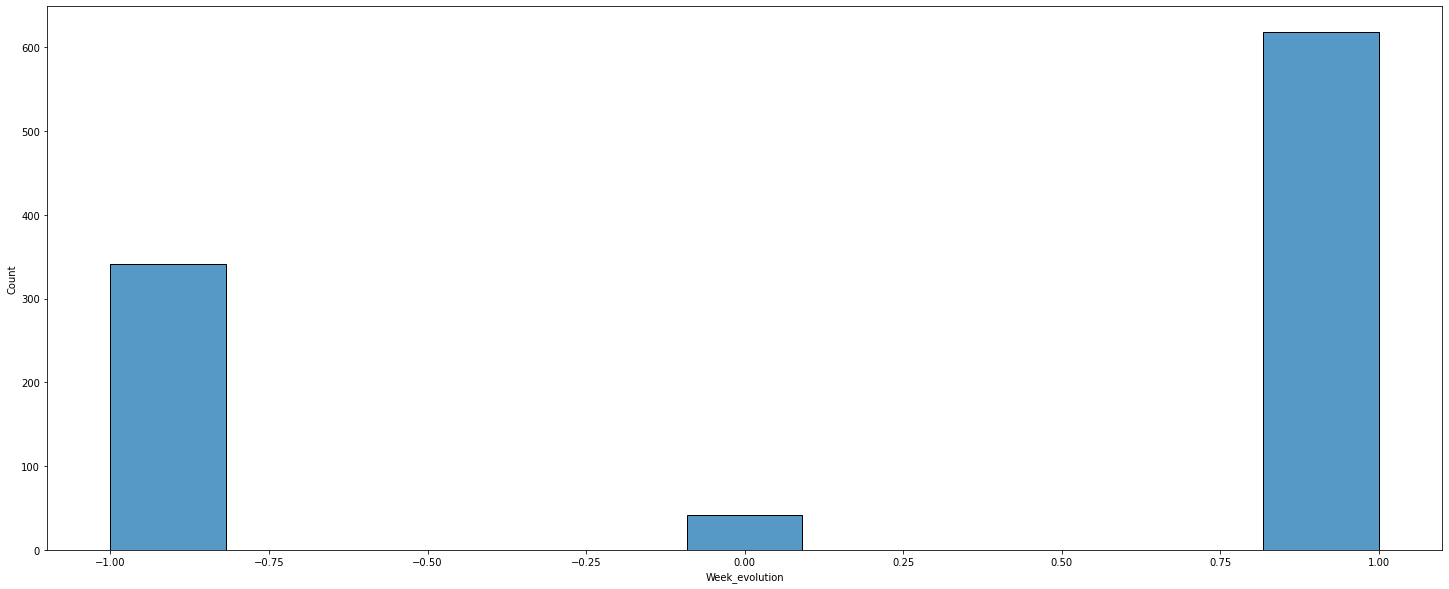

In [128]:
sns.histplot(data=indicators, x='Week_evolution')

## 2.2- Signal indicators (features)

### 2.2.1- Feature engineering process

In order to tune the different technical indicators proposed, a gridsearch will be deployed. Every of the studied technical tools have a widespread criteria to identify signals for the market direction going upwards/downwards (crossing of the moving averages, null value of the MACD cummulative distribution, RSI of 30/70 etc).

This criteria is evaluated to generate a vector of -1/0/1 values predicting the weekly market direction. The accuracy (proportion of matching values) and precision (proportion of correct -1/1 signals) is presented for each combination of parameters. 

The best performing parameters will be chosen to generate the features to be later fed to the deep neural network.

### 2.2.2- Moving averages

Moving averages is one of the most common and straight-forward indicators in technical analysis. We can compute them easily with no need of specialised libraries.

The moving averages can be used to signal when the market is likely to go up or down by studying when different SMA cross or when the SMA and the price cross (the least smoothed signal crossing upwards a more smoothed signal indicates a potential upwards change of tendency in the price, and viceversa).

A custom function is created to generate the signal depending on the crossing events.

In [129]:
def signal_crossing(signal_1:pd.Series, signal_2:pd.Series)->pd.Series:
  # This function compares two time series and returns a 0 for every time point without crossing events,
  # 1 when signal_1 crosses signal_2 upwards and -1 when signal_1 crosses downwards signal_2
  new_series = pd.Series(dtype='float64')
  for idx in range(1, len(signal_1)):
    if signal_1.iloc[idx] > signal_2.iloc[idx] and signal_1.iloc[idx-1] < signal_2.iloc[idx-1]:
      new_series.loc[idx]=1
    elif signal_1.iloc[idx] < signal_2.iloc[idx] and signal_1.iloc[idx-1] > signal_2.iloc[idx-1]:
      new_series.loc[idx]=-1
    else:
      new_series.loc[idx]=0
  return new_series

A new dataframe is created to populate it while optimising the parameters.

In [130]:
ma_df = indicators[['Date', 'Close', 'Week_evolution']]

In [131]:
pd.options.mode.chained_assignment = None
MA_grid = {  
    'window_slow': [4, 6, 8, 10, 12, 14, 18, 20, 22],
    'window_fast': [1, 2, 4, 6, 8, 10, 12, 14],
}
# Generate all combinations of parameters
all_MA_params = [dict(zip(MA_grid.keys(), v)) for v in itertools.product(*MA_grid.values())]
#Leave only the param sets where the fast MA period is lower than the slow MA period
all_MA_params = [dict for dict in all_MA_params if (dict['window_fast'] < dict['window_slow'])]
# Loop over all the sets of parameters
for param_set in all_MA_params:
  ma_df['ma_fast'] = candles['Close'].transform(lambda x: x.rolling(window = param_set['window_fast']).mean())
  ma_df['ma_slow'] = candles['Close'].transform(lambda x: x.rolling(window = param_set['window_slow']).mean())
  ma_df['MA_signal'] = signal_crossing(ma_df['ma_fast'], ma_df['ma_slow'])
  ma_df.fillna(0, inplace=True)
  # Extract only the rows where the predicted direction is non-neutral
  ma_signals = ma_df.loc[ma_df['MA_signal'] != 0]
  # Days for which the signal can be evaluated (discarding the first days for 
  # which the ma is not available and the last days for which the direction for the following week is unknown)
  available_days = len(ma_df)-param_set['window_slow']-5
  # Evaluate the accuracy and the precision
  accuracy = (ma_df['MA_signal'] == ma_df['Week_evolution']).sum() / available_days *100
  precision = (ma_signals['MA_signal'] == ma_signals['Week_evolution']).sum() / available_days *100
  # Capture the parameters since f-string gives an error when unpacking the dict
  fast_period = param_set['window_fast']
  slow_period = param_set['window_slow']
  print(f'MA periods of {fast_period}-{slow_period}: Accuracy = {accuracy:.2f}% Precision = {precision:.2f}% #Signals {len(ma_signals)}')


MA periods of 1-4: Accuracy = 17.05% Precision = 13.44% #Signals 289
MA periods of 2-4: Accuracy = 15.45% Precision = 11.94% #Signals 250
MA periods of 1-6: Accuracy = 14.07% Precision = 9.95% #Signals 215
MA periods of 2-6: Accuracy = 12.96% Precision = 8.54% #Signals 165
MA periods of 4-6: Accuracy = 12.76% Precision = 8.54% #Signals 170
MA periods of 1-8: Accuracy = 12.39% Precision = 8.46% #Signals 174
MA periods of 2-8: Accuracy = 11.58% Precision = 7.25% #Signals 148
MA periods of 4-8: Accuracy = 10.37% Precision = 6.24% #Signals 125
MA periods of 6-8: Accuracy = 11.68% Precision = 7.45% #Signals 144
MA periods of 1-10: Accuracy = 11.71% Precision = 7.57% #Signals 146
MA periods of 2-10: Accuracy = 10.70% Precision = 6.05% #Signals 111
MA periods of 4-10: Accuracy = 9.49% Precision = 4.94% #Signals 95
MA periods of 6-10: Accuracy = 10.09% Precision = 5.55% #Signals 97
MA periods of 8-10: Accuracy = 11.81% Precision = 7.16% #Signals 116
MA periods of 1-12: Accuracy = 11.53% Precis

The performance of the different sets of parameters increases as the period decreases. It can be hypothesized that wide periods miss many buy and sell signals, hence scoring low in accuracy and precision.

In [132]:
ma_df['ma_fast'] = candles['Close'].transform(lambda x: x.rolling(window = 1).mean())
ma_df['ma_slow'] = candles['Close'].transform(lambda x: x.rolling(window = 4).mean())
indicators['ma_optimum'] = signal_crossing(ma_df['ma_fast'], ma_df['ma_slow'])

### 2.2.3-MACD difference

The MACD is a similar indicator tho the MA crossing, with the difference of using exponential moving averages instead of simple ones. 

The same optimisation process is followed for the MACD indicator, which signals to buy or sell when the two EMA cross.

In [133]:
def MACD_evolution(prices:pd.Series)->int:
  #Since we apply this function with a rolling window, the input is a pnadas Serie
  initial_value = prices.iloc[0]
  final_value = prices.iloc[-1]
  #
  if ((final_value > 0) and (initial_value < 0)):
    return 1
  elif ((final_value < 0) and (initial_value > 0)):
    return -1
  else:
    return 0

In [134]:
MACD_grid = {  
    'window_slow': [4, 6, 8, 10, 12, 14, 18, 22],
    'window_fast': [1, 2, 4, 6, 8, 10],
    'window_sign': [3, 6, 9],
    'fillna': [False]
}
# Generate all combinations of parameters
all_MACD_params = [dict(zip(MACD_grid.keys(), v)) for v in itertools.product(*MACD_grid.values())]
#Leave only the param sets where the fast MA period is lower than the slow MA period
all_MACD_params = [dict for dict in all_MACD_params if (dict['window_fast'] < dict['window_slow'])]
# Iterate over all the sets of parameters
for param_set in all_MACD_params:
  indicators['MACD_diff']=ta.trend.MACD(candles['Close'], **param_set).macd_diff()
  indicators['MACD_signal'] = indicators['MACD_diff'].rolling(window=2).apply(MACD_evolution)
  indicators.fillna(0, inplace=True)
  MACD_signals = indicators.loc[indicators['MACD_signal'] != 0]
  available_days = len(indicators)-param_set['window_slow']-5
  accuracy = (indicators['MACD_signal'] == indicators['Week_evolution']).sum() / available_days *100
  precision = (MACD_signals['MACD_signal'] == MACD_signals['Week_evolution']).sum() / available_days *100
  fast_period = param_set['window_fast']
  slow_period = param_set['window_slow']
  signal_period = param_set['window_sign']
  print(f'MACD period of {fast_period}-{slow_period}-{signal_period}: Accuracy = {accuracy:.2f}% Precision = {precision:.2f}% #Signals {len(MACD_signals)}')


MACD period of 1-4-3: Accuracy = 22.97% Precision = 20.46% #Signals 446
MACD period of 1-4-6: Accuracy = 20.66% Precision = 17.65% #Signals 379
MACD period of 1-4-9: Accuracy = 19.86% Precision = 16.75% #Signals 361
MACD period of 2-4-3: Accuracy = 18.56% Precision = 15.75% #Signals 349
MACD period of 2-4-6: Accuracy = 16.65% Precision = 13.24% #Signals 291
MACD period of 2-4-9: Accuracy = 15.95% Precision = 12.34% #Signals 271
MACD period of 1-6-3: Accuracy = 21.81% Precision = 19.10% #Signals 412
MACD period of 1-6-6: Accuracy = 19.40% Precision = 16.18% #Signals 347
MACD period of 1-6-9: Accuracy = 18.19% Precision = 14.67% #Signals 316
MACD period of 2-6-3: Accuracy = 17.19% Precision = 14.17% #Signals 320
MACD period of 2-6-6: Accuracy = 15.68% Precision = 11.96% #Signals 257
MACD period of 2-6-9: Accuracy = 15.18% Precision = 11.36% #Signals 236
MACD period of 4-6-3: Accuracy = 15.38% Precision = 11.66% #Signals 248
MACD period of 4-6-6: Accuracy = 12.96% Precision = 8.94% #Signa

Similarly to the simple moving averages case, the narrower the periods the more accurate and precise is the signal produced. 

**Very interestingly when having less signals with wider periods, the precision of these few signals is not any better of the larger set of signals obtained for narrower MA periods**

In [135]:
indicators['MACD_optimum']=ta.trend.MACD(candles['Close'], window_fast=1, window_slow=4, window_sign=3, fillna=True).macd_diff()

### 2.2.4-Relative Strength Index (RSI)

The relative strength index (RSI) in short indicates when the market can be considered to be overbought or oversold. This is identified by the commonly used threshold values of 30 and 70. Without playing around with these two threshold values, we can optimise the RSI window length following a similar method as the one performed before.

In [136]:
for window_len in range(1, 22, 1):
  indicators['RSI_value']=ta.momentum.RSIIndicator(close=candles['Close'], window=window_len, fillna=False).rsi()
  indicators['RSI_signal'] = [1 if rsi>70 else -1 if rsi<30 else 0 for rsi in indicators['RSI_value']]
  indicators.fillna(0, inplace=True)
  RSI_signals = indicators.loc[indicators['RSI_signal'] != 0]
  available_days = len(indicators)-window_len-5
  accuracy = (indicators['RSI_signal'] == indicators['Week_evolution']).sum() / available_days *100
  precision = (RSI_signals['RSI_signal'] == RSI_signals['Week_evolution']).sum() / available_days *100

  print(f'RSI period of {window_len}: Accuracy = {accuracy:.2f}% Precision = {precision:.2f}% #Signals {len(RSI_signals)}')


RSI period of 1: Accuracy = 49.30% Precision = 49.30% #Signals 1006
RSI period of 2: Accuracy = 38.54% Precision = 37.24% #Signals 704
RSI period of 3: Accuracy = 32.06% Precision = 30.16% #Signals 558
RSI period of 4: Accuracy = 27.98% Precision = 25.98% #Signals 488
RSI period of 5: Accuracy = 24.00% Precision = 21.89% #Signals 424
RSI period of 6: Accuracy = 21.11% Precision = 18.79% #Signals 377
RSI period of 7: Accuracy = 18.41% Precision = 15.90% #Signals 319
RSI period of 8: Accuracy = 16.21% Precision = 13.49% #Signals 269
RSI period of 9: Accuracy = 15.32% Precision = 12.30% #Signals 240
RSI period of 10: Accuracy = 15.04% Precision = 11.60% #Signals 218
RSI period of 11: Accuracy = 13.94% Precision = 10.40% #Signals 193
RSI period of 12: Accuracy = 13.14% Precision = 9.20% #Signals 172
RSI period of 13: Accuracy = 12.25% Precision = 8.10% #Signals 149
RSI period of 14: Accuracy = 10.94% Precision = 6.79% #Signals 130
RSI period of 15: Accuracy = 10.45% Precision = 6.19% #Sign

In [137]:
indicators['RSI_optimum']=ta.momentum.RSIIndicator(close=candles['Close'], window=2, fillna=False).rsi()

### 2.2.5- Prophet signal

The time series forecasting algorithm Prophet is another useful tool to get a prediction in the market direction for any given day. Fitting the model to all the previous days we can get a forecast with any desired period length, as well as the confidence bands for the forecast. 

In [41]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
import itertools

The prophet model use as input a pandas datafame with column name 'ds' for the datestamp and 'y' for the timeseries values.

In [42]:
# Create a new dataframe with the relevant columns and modify the column names
data_prophet = indicators[['Date', 'Close']]
data_prophet.columns = ['ds', 'y']

In [43]:
data_prophet.head()

,ds,y
0,2017-06-14,2437.919922
1,2017-06-15,2432.459961
2,2017-06-16,2433.149902
3,2017-06-19,2453.459961
4,2017-06-20,2437.030029


#### Prophet hyperparameter tunning

According to the Prophet docs, the two parameters recommended to be tuned are the 'changepoint_prior_scale' and the 'seasonality_prior_scale'. For this we use the built-in functions cross_validation and performance_metrics from the fbprophet library.

In [25]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10],
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
prophet_rmses = []  # Store the RMSEs for each params here

In [ ]:
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data_prophet)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', period='365 days', parallel="threads")
    df_p = performance_metrics(df_cv, rolling_window=1)
    prophet_rmses.append(df_p['rmse'].values[0])

In [27]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = prophet_rmses
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  381.575242
1                     0.001                     0.10  380.300553
2                     0.001                     1.00  382.442460
3                     0.001                    10.00  382.052637
4                     0.010                     0.01   86.264220
5                     0.010                     0.10   89.801803
6                     0.010                     1.00   82.359267
7                     0.010                    10.00   84.790880
8                     0.100                     0.01  187.003189
9                     0.100                     0.10  171.335086
10                    0.100                     1.00  174.925633
11                    0.100                    10.00  178.105420
12                    1.000                     0.01  120.763275
13                    1.000                     0.10   76.794246
14                    1.0

A Changepoint_prior_scale value of 1.0 and a seasonality_prior_scale value of 10.0 will be kept to be used for the further optimisation of the fitting window.

#### Optimize the training window

We define a function to retrieve the model parameters and ease the warm start of the model fitting when only adding the new day values.

In [33]:
def stan_init(m):
    """Retrieve parameters from a trained model.
    
    Retrieve parameters from a trained model in the format
    used to initialize a new Stan model.
    
    Parameters
    ----------
    m: A trained model of the Prophet class.
    
    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

We optimise the window of past datapoints used to train the model for any give present day by predicting the next week price for every day using the 3 considered windows (60, 120 and 240 weekdays) and converting it into price variation (next week value - current value).

In [ ]:
prophet_direction = data_prophet
passing_issues=0
modelled_params = {}
for window_len in [60, 120, 240]:
  #Create a new column for the new window length
  prophet_direction.loc[:, str(window_len)] = np.nan

  for day in range(window_len, len(data_prophet)-5, 1):
    print(f'Modelling day {day} with window {window_len}')
    prophet_train = data_prophet.iloc[:day, :]
    # The model can only be fitted once after instantiating it, so we do it inside the loop
    prophet_model = Prophet(changepoint_prior_scale=1, seasonality_prior_scale=0.01)
    if not modelled_params: # We are fitting for the first time
      prophet_model.fit(prophet_train)
    else:
      new_data = data_prophet.iloc[window_len, :]
      # We use the parameters from the previous model to warm start the new one
      try :
        prophet_model.fit(new_data, init=modelled_params)
      except:
        prophet_model = Prophet(changepoint_prior_scale=1, seasonality_prior_scale=0.01)
        prophet_model.fit(prophet_train)
    # we store the parameters for the next model
    if prophet_model.params:
      modelled_params = stan_init(prophet_model)
    else:
      modelled_params = {}
    future = prophet_model.make_future_dataframe(periods=8, freq = 'd')
    #We remove the weekends
    future['day'] = future['ds'].dt.weekday
    future = future.loc[future['day']<=4, :]
    #We perfomr the one week forecast
    forecast = prophet_model.predict(future)
    variation = forecast.loc[forecast.index[-1], 'yhat'] - data_prophet.loc[day, 'y']
    prophet_direction.loc[day, [str(window_len)]] = variation

These two lines of codes are only here to be able to export/import the results of the previous timeconsuming optimisation process.

In [281]:
prophet_direction.to_csv('prophet_optimisation_wsignals.csv')

In [33]:
prophet_direction = pd.read_csv('prophet_optimisation_wsignals.csv')

The price variation vectors are converted into price direction vectors in order to calculate the accuracies. Again this can be done applying a lambda with a custom function.

In [35]:
def price_direction(element)->int:
  stock_value = 4200
  if element > stock_value*0.001:
    return 1
  elif element < -stock_value*0.001:
    return -1
  else:
    return 0

In [36]:
prophet_direction['60_direction'] = prophet_direction['60'].apply(lambda x: price_direction(x))
prophet_direction['120_direction'] = prophet_direction['120'].apply(lambda x: price_direction(x))
prophet_direction['240_direction'] = prophet_direction['240'].apply(lambda x: price_direction(x))

We create a new dataframe with the indicators dataframe in order to have the target and the signal columns in the same dataframe.

In [37]:
indicators['Date']=indicators['Date'].astype('datetime64')
prophet_direction['ds'] = prophet_direction['ds'].astype('datetime64')

In [38]:
prophet_labelled = indicators.merge(prophet_direction, how='inner', left_on='Date', right_on='ds')

In [39]:
prophet_labelled.head()

,Date,Week_evolution,Day_evolution,Week_difference,Day_difference,Close,ma_optimum,MACD_diff,MACD_signal,MACD_optimum,RSI_value,RSI_signal,RSI_optimum,Unnamed: 0,ds,y,60,120,240,60_direction,120_direction,240_direction
0,2017-06-15,0.0,0.0,2.040039,0.689941,2432.459961,0.0,0.0,0.0,0.000000,0.0,0,NaN,2,2017-06-15,2432.459961,NaN,NaN,NaN,0,0,0
1,2017-06-16,1.0,1.0,5.150146,20.310059,2433.149902,0.0,0.0,0.0,0.206982,0.0,0,100.000000,3,2017-06-16,2433.149902,NaN,NaN,NaN,0,0,0
2,2017-06-19,-1.0,-1.0,-14.389893,-16.429932,2453.459961,0.0,0.0,0.0,6.113716,0.0,0,100.000000,4,2017-06-19,2453.459961,NaN,NaN,NaN,0,0,0
3,2017-06-20,-1.0,0.0,-17.650146,-1.419922,2437.030029,0.0,0.0,0.0,-4.359004,0.0,0,38.596787,5,2017-06-20,2437.030029,NaN,NaN,NaN,0,0,0
4,2017-06-21,1.0,0.0,5.079834,-1.110107,2435.610107,0.0,0.0,0.0,-2.126017,0.0,0,34.893447,6,2017-06-21,2435.610107,NaN,NaN,NaN,0,0,0


Now we can calculate the accuracy and the precision of both the buying and selling signals.

In [40]:
for name, compensation in zip(['60_direction', '120_direction', '240_direction'], [60, 120, 240]):
  available_days = len(prophet_labelled) - compensation - 5
  accuracy = (prophet_labelled['Week_evolution'] == prophet_labelled['60_direction']).sum() / available_days *100 
  print(f'The accuracy using a fitting window of {compensation} days is {accuracy} %')

The accuracy using a fitting window of 60 days is 48.08510638297872 %
The accuracy using a fitting window of 120 days is 51.36363636363637 %
The accuracy using a fitting window of 240 days is 59.473684210526315 %


In [41]:
for name, compensation in zip(['60_direction', '120_direction', '240_direction'], [60, 120, 240]):
  df_signals = prophet_labelled.loc[prophet_labelled[name] == 1, :]
  available_days = len(df_signals)
  precision = (df_signals['Week_evolution'] == df_signals['60_direction']).sum() / available_days *100 
  print(f'The precision of the buy signal using a fitting window of {compensation} days is {precision} %')

The precision of the buy signal using a fitting window of 60 days is 62.32179226069247 %
The precision of the buy signal using a fitting window of 120 days is 61.16071428571429 %
The precision of the buy signal using a fitting window of 240 days is 60.25 %


In [42]:
for name, compensation in zip(['60_direction', '120_direction', '240_direction'], [60, 120, 240]):
  df_signals = prophet_labelled.loc[prophet_labelled[name] == -1, :]
  available_days = len(df_signals)
  precision = (df_signals['Week_evolution'] == df_signals['60_direction']).sum() / available_days *100 
  print(f'The precision of the buy signal using a fitting window of {compensation} days is {precision} %')

The precision of the buy signal using a fitting window of 60 days is 33.582089552238806 %
The precision of the buy signal using a fitting window of 120 days is 34.096692111959285 %
The precision of the buy signal using a fitting window of 240 days is 32.52279635258359 %


In [138]:
indicators['prophet_optimum'] = df_signals['240_direction']

### 2.2.6- Sentiment signal

The dataframe with the sentiment data from finantial news scraped and processed with the fine-tunned finBERT model is imported and cleaned to select only the days with more than 20 news (thus dropping weekends)

In [54]:
sent_df = pd.read_csv('news_sentiment_data.csv')
sent_df = sent_df.loc[sent_df['Head_Pos_y']>10, :]
sent_df.head()

,date,Head_Pos_x,Head_neutral_x,Head_Neg_x,Body_Pos_x,Body_neutral_x,Body_Neg_x,Summ_Head,Summ_Body,Head_Pos_y,Head_neutral_y,Head_Neg_y,Body_Pos_y,Body_neutral_y,Body_Neg_y
13,2021-03-12,0.211117,0.120124,0.668759,0.173189,0.186587,0.640224,-0.457642,-0.467035,11,11,11,11,11,11
16,2021-03-15,0.322917,0.264581,0.412502,0.456975,0.388529,0.154496,-0.089585,0.302479,37,37,37,37,37,37
17,2021-03-16,0.375604,0.300247,0.324149,0.326206,0.477734,0.196060,0.051456,0.130146,59,59,59,59,59,59
18,2021-03-17,0.297586,0.328815,0.373599,0.360851,0.436148,0.203001,-0.076013,0.157849,60,60,60,60,60,60
19,2021-03-18,0.328113,0.386985,0.284902,0.348881,0.511252,0.139867,0.043211,0.209014,66,66,66,66,66,66


In [142]:
sent_df['date'] = sent_df['date'].astype('datetime64')

In [143]:
indicators_final = indicators.merge(right=sent_df.loc[:, ['date', 'Summ_Head', 'Summ_Body']], how='outer', left_on='Date', right_on='date')

In [144]:
indicators_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008 entries, 0 to 1007
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1006 non-null   datetime64[ns]
 1   Week_evolution   1006 non-null   float64       
 2   Day_evolution    1006 non-null   float64       
 3   Week_difference  1006 non-null   float64       
 4   Day_difference   1006 non-null   float64       
 5   Close            1006 non-null   float64       
 6   ma_optimum       1006 non-null   float64       
 7   MACD_diff        1006 non-null   float64       
 8   MACD_signal      1006 non-null   float64       
 9   MACD_optimum     1006 non-null   float64       
 10  RSI_value        1006 non-null   float64       
 11  RSI_signal       1006 non-null   float64       
 12  RSI_optimum      1005 non-null   float64       
 13  prophet_optimum  329 non-null    float64       
 14  date             45 non-null     datetim

## 2.3- Cleaning the indicators df

The elements close to the margin have NaN values, so we impute them with 0 (no signal for the indicators like SMA and no evolution for the targets).

In [145]:
indicators_final.fillna(0, inplace=True)

In [146]:
indicators_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008 entries, 0 to 1007
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             1008 non-null   object 
 1   Week_evolution   1008 non-null   float64
 2   Day_evolution    1008 non-null   float64
 3   Week_difference  1008 non-null   float64
 4   Day_difference   1008 non-null   float64
 5   Close            1008 non-null   float64
 6   ma_optimum       1008 non-null   float64
 7   MACD_diff        1008 non-null   float64
 8   MACD_signal      1008 non-null   float64
 9   MACD_optimum     1008 non-null   float64
 10  RSI_value        1008 non-null   float64
 11  RSI_signal       1008 non-null   float64
 12  RSI_optimum      1008 non-null   float64
 13  prophet_optimum  1008 non-null   float64
 14  date             1008 non-null   object 
 15  Summ_Head        1008 non-null   float64
 16  Summ_Body        1008 non-null   float64
dtypes: float64(15)

# 3- Deep learning model

In [158]:
import torch
import torch.nn as nn
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

# 3.1- Dataloader instance

We use the primitives dataloader and dataset to create an iterable with the input data

In [95]:
class Data(Dataset):
    def __init__(self, x_train, y_train):
        self.x=torch.from_numpy(x_train)
        self.y=torch.from_numpy(y_train)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

# 3.2- Test and training sets

This next chunk is only to create the train and test datasets without considering the sentiment data.

In [205]:
features = indicators_final.loc[:,['Week_evolution', 'RSI_optimum', 'MACD_optimum', 'ma_optimum', 'prophet_optimum']]
target = features['Week_evolution'].values.astype('float')
features.drop('Week_evolution', axis=1, inplace=True)

features = features.values.astype('float')

#Label encoding since Pytorch CrossEntropy loss function does not deal with negative values
lab_enc = LabelEncoder()
target = lab_enc.fit_transform(target)

X_train,X_test,y_train,y_test = train_test_split(features,target, test_size=0.4, random_state=22)

The next two code cells prepare the input and target data for the nn with stratifying the train and test split, so both sets have the same proportion of non-null values for the sentiment rows.

In [218]:
def train_test_strat_sent(features_df:pd.DataFrame, test_size:float, random_state:int, sent_col_name:str='Summ_Head'): 
  # This funtion gets a df, test set proportion and random seed and returns an
  # stratified split of the input data, using the sent_col_name column name to 
  # locate the column which will dictate the stratification. This stratification
  # is performed separating the rows with null and non-null values for this column.

  features_with_sent = features.loc[features[sent_col_name] != 0, :]
  features_no_sent = features.loc[features[sent_col_name] == 0, :]

  target_nosent = features_no_sent['Week_evolution'].values.astype('float')
  features_no_sent.drop('Week_evolution', axis=1, inplace=True)
  target_with_sent = features_with_sent['Week_evolution'].values.astype('float')
  features_with_sent.drop('Week_evolution', axis=1, inplace=True)

  features_with_sent = features_with_sent.values.astype('float')
  features_no_sent = features_no_sent.values.astype('float')
  #Label encoding since Pytorch CrossEntropy loss function does not deal with negative values
  lab_enc = LabelEncoder()
  target_nosent = lab_enc.fit_transform(target_nosent)
  target_with_sent = lab_enc.transform(target_with_sent)

  X_train_nosent,X_test_nosent,y_train_nosent,y_test_nosent = train_test_split(features_no_sent,target_nosent, test_size=test_size, random_state=random_state)
  X_train_withsent,X_test_withsent,y_train_withsent,y_test_withsent = train_test_split(features_with_sent,target_with_sent,test_size=test_size, random_state=random_state)

  X_train = np.concatenate((X_train_nosent, X_train_withsent), axis=0)
  X_test = np.concatenate((X_test_nosent, X_test_withsent), axis=0)
  y_train = np.concatenate((y_train_nosent, y_train_withsent), axis=0)
  y_test = np.concatenate((y_test_nosent, y_test_withsent), axis=0)
  return X_train, X_test, y_train, y_test

In [219]:
features = indicators_final.loc[:,['Week_evolution', 'RSI_optimum', 'MACD_optimum', 'ma_optimum', 'prophet_optimum', 'Summ_Head', 'Summ_Body']]
X_train, X_test, y_train, y_test = train_test_strat_sent(features_df=features, random_state=22, test_size=0.5)

In [220]:
data_set=Data(x_train=X_train, y_train=y_train)
trainloader=DataLoader(dataset=data_set,batch_size=int(len(X_train)/1))

# 3.3- Model definition

Model parameters are defined as below:

In [221]:
input_dim=6     # how many Variables are in the dataset
hidden_dim = 25 # hidden layers
output_dim=3    # number of classes

In [222]:
class DNN_Model(nn.Module):
  def __init__(self, D_in, H1, H2, H3, D_out):
    super(DNN_Model, self).__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, H3)
    self.linear4 = nn.Linear(H3, D_out)

  def forward(self, x):
    x = torch.sigmoid(self.linear1(x))
    x = torch.sigmoid(self.linear2(x))
    x = torch.sigmoid(self.linear3(x))
    x = self.linear4(x)
    return x

Instantiate a first deep model

In [223]:
# Instantiate model
dnn_model=DNN_Model(input_dim, hidden_dim, hidden_dim, hidden_dim, output_dim)
loss_dnn = nn.CrossEntropyLoss(reduction='mean')
learning_rate_dnn = 1e-2
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=learning_rate_dnn)

In [203]:
len(target_tensor)

202

In [224]:
n_epochs=10000
loss_list=[]
target_tensor = torch.Tensor(y_test)
#n_epochs
for epoch in range(n_epochs):
    for x, y in trainloader:

        x = x.float()
        y = y.long()
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z=dnn_model(x)
        # calculate loss
        loss=loss_dnn(z,y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        
        loss_list.append(loss.data)
        
        correct = (torch.max(z.data,1).indices == y).sum()
        training_accuracy = correct/len(z)*100
        tensor_test = torch.Tensor(X_test)
        dnn_pred = dnn_model(tensor_test)
        correct_pred = (torch.max(dnn_pred.data,1).indices == target_tensor).sum()
        test_accuracy = correct_pred/len(target_tensor)*100
        print(f'epoch {epoch}, loss {loss.item():.5f}, training accuracy {training_accuracy:.2f}%, test accuracy {test_accuracy:.2f}%')

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
epoch 5000, loss 0.48420, training accuracy 78.13%, test accuracy 51.68%
epoch 5001, loss 0.48514, training accuracy 78.53%, test accuracy 52.28%
epoch 5002, loss 0.48706, training accuracy 77.73%, test accuracy 51.09%
epoch 5003, loss 0.48773, training accuracy 78.53%, test accuracy 51.88%
epoch 5004, loss 0.48992, training accuracy 77.53%, test accuracy 50.50%
epoch 5005, loss 0.48993, training accuracy 78.73%, test accuracy 51.68%
epoch 5006, loss 0.49174, training accuracy 77.53%, test accuracy 50.10%
epoch 5007, loss 0.49038, training accuracy 78.53%, test accuracy 51.88%
epoch 5008, loss 0.49019, training accuracy 77.53%, test accuracy 50.50%
epoch 5009, loss 0.48749, training accuracy 78.53%, test accuracy 52.08%
epoch 5010, loss 0.48578, training accuracy 77.93%, test accuracy 51.49%
epoch 5011, loss 0.48316, training accuracy 77.53%, test accuracy 51.49%
epoch 5012, loss 0.48113, training accuracy 78

In [211]:
dnn_data = torch.Tensor(features)

In [212]:
# evaluate model:
dnn_model.eval()

with torch.no_grad():
  out_data = dnn_model(dnn_data)


In [213]:
final_strategy = torch.max(out_data,1).indices
final_strategy=lab_enc.inverse_transform(np.array(final_strategy.tolist()))

# 4- Backtesting

In [255]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In this section we create a custom backtesting parent class with all the base methods and a child class optimised for shrot-long positioning.

The code is a version of the code proposed by:

> **Python for Algorithmic Trading**

> *(c) Dr. Yves J. Hilpisch*

> The Python Quants GmbH


In [108]:
class BaseBacktesting(object): 
  ''' Base class for event-based backtesting of trading strategies.
  Attributes
  ==========
  symbol: str
      TR RIC (financial instrument) to be used. If the .csv file has the 
      Yahoo Finance format, the pricing element must be specified insted 
      (i.e. "Close").
  start: str
      start date for data selection
  end: str
      end date for data selection
  amount: float
      amount to be invested either once or per trade
  datapath: string
      path to the csv file to be imported
  ftc: float
      fixed transaction costs per trade (buy or sell). 
  ptc: float
      proportional transaction costs per trade (buy or sell)

  Methods
  =======
  get_data:
      retrieves and prepares the base data set
  plot_data:
      plots the closing price for the symbol
  get_date_price:
      returns the date and price for the given bar
  print_balance:
      prints out the current (cash) balance
  print_net_wealth:
      prints out the current net wealth
  place_buy_order:
      places a buy order
  place_sell_order:
      places a sell order
  close_out:
      closes out a long or short position
  '''
  def __init__(self, symbol, start, end, amount, datapath, 
               ftc=0.0, ptc=0.0, verbose=True):
    self.symbol = symbol
    self.start = start
    self.end = end
    self.initial_amount = amount
    self.amount = amount
    self.datapath = datapath
    self.ftc = ftc
    self.ptc = ptc
    self.units = 0
    self.position = 0
    self.trades = 0
    self.verbose = verbose
    self.net_wealth_serie = []
    self.get_data()

  def get_data(self):
    ''' Retrieves and prepares the data.
    '''
    raw = pd.read_csv(self.datapath, index_col=0, parse_dates=True).dropna()
    raw = pd.DataFrame(raw[self.symbol])
    raw = raw.loc[self.start:self.end]
    raw.rename(columns={self.symbol: 'price'}, inplace=True)
    raw['return'] = np.log(raw / raw.shift(1))
    self.data = raw.fillna(0)

  def plot_data(self, cols=None):
    ''' Plots the closing prices for symbol.
    '''
    if cols is None:
      cols = ['price']
    self.data['price'].plot(figsize=(10, 6), title=self.symbol)

  def get_date_price(self, bar):
    ''' Return date and price for bar.
    '''
    date = str(self.data.index[bar])[:10]
    price = self.data.price.iloc[bar]
    return date, price

  def print_balance(self, bar):
    ''' Print out current cash balance info.
    '''
    date, price = self.get_date_price(bar)
    print(f'{date} | current balance {self.amount:.2f}')

  def print_net_wealth(self, bar):
    ''' Print out current cash balance info.
    '''
    date, price = self.get_date_price(bar)
    net_wealth = self.units * price + self.amount
    print(f'{date} | current net wealth {net_wealth:.2f}')

  def get_net_wealth(self, bar):
    ''' Get current cash balance info.
    '''
    date, price = self.get_date_price(bar)
    return self.units * price + self.amount

  def place_buy_order(self, bar, units=None, amount=None):
    ''' Place a buy order.
    '''
    date, price = self.get_date_price(bar)
    if units is None:
      units = int(amount / price)
    self.amount -= (units * price) * (1 + self.ptc) + self.ftc
    self.units += units
    self.trades += 1
    if self.verbose:
      print(f'{date} | buying {units} units at {price:.2f}')
      self.print_balance(bar)
      self.print_net_wealth(bar)

  def place_sell_order(self, bar, units=None, amount=None):
    ''' Place a sell order.
    '''
    date, price = self.get_date_price(bar)
    if units is None:
      units = int(amount / price)
    self.amount += (units * price) * (1 - self.ptc) - self.ftc
    self.units -= units
    self.trades += 1
    if self.verbose:
      print(f'{date} | selling {units} units at {price:.2f}')
      self.print_balance(bar)
      self.print_net_wealth(bar)

  def close_out(self, bar):
    ''' Closing out a long or short position. To be used at the end of the 
    backtesting strategy, to translate the assets involved in the open 
    positions into liquidity.
        '''
    date, price = self.get_date_price(bar)
    self.amount += self.units * price
    self.units = 0
    self.trades += 1
    if self.verbose:
      print(f'{date} | inventory {self.units} units at {price:.2f}')
      print('=' * 55)
      print('Final balance [$] {:.2f}'.format(self.amount))
      perf = ((self.amount - self.initial_amount) /
      self.initial_amount * 100)
      print('Net Performance [%] {:.2f}'.format(perf))
      print('Trades Executed [#] {:.2f}'.format(self.trades))
      print('=' * 55)

In [300]:
class BacktestLongShort(BaseBacktesting):

  def go_long(self, bar, units=None, amount=None):
      #Note that no alternative is presented for the case in which neither 
      #unit or amount is defined.
    if self.position == -1: #If the position is short, close it
      self.place_buy_order(bar, units=-self.units)
    #Open a new position
    if units:
      self.place_buy_order(bar, units=units)
    elif amount:
      if amount == 'all':
        amount = self.amount
      elif isinstance(amount, (float,int)):
        amount = self.amount*amount
      self.place_buy_order(bar, amount=amount)

  def go_short(self, bar, units=None, amount=None):
      #Note that no alternative is presented for the case in which neither 
      #unit or amount is defined.
    if self.position == 1: #If the position is long, close it
      self.place_sell_order(bar, units=self.units)
      #Open a new position
    if units:
      self.place_sell_order(bar, units=units)
    elif amount:
      if amount == 'all':
        amount = self.amount
      elif isinstance(amount, (float,int)):
        amount = self.amount*amount
      self.place_sell_order(bar, amount=amount)

  def run_by_matrix(self, signals:pd.Series, units_per_trade=None, amount_per_trade='all', min_signals=1, verbose=True, plot_result=True):
    ''' This method implements the strategy based on a matrix of signals
    for positioning short (-1) or long (1) on the market
    '''
    msg = f'\n\nRunning strategy based on a matrix of signals'
    msg += f'\nfixed costs {self.ftc} | '
    msg += f'proportional costs {self.ptc}'
    print(msg)
    self.net_wealth_serie = [] #Re-initialise the net_wealth_serie list
    self.verbose = verbose #Give the possibility to explicit verbosity
    self.position = 0 # initial neutral position
    self.trades = 0 # no trades yet
    self.amount = self.initial_amount # reset initial capital
    for bar in range(len(self.data)):
      if (sum([signals.iloc[bar]]) >= min_signals) and self.position != 1:
        self.go_long(bar, units=units_per_trade, amount=amount_per_trade)
        self.position = 1 # long position
      if (sum([signals.iloc[bar]]) <= -min_signals) and self.position != -1:
        self.go_short(bar, units=units_per_trade, amount=amount_per_trade)
        self.position = -1 # short position
      self.net_wealth_serie.append(self.get_net_wealth(bar))
    self.close_out(bar)
    if plot_result:
      self.plot_vector_strategy(signals)

  def plot_vector_strategy(self, unidim_matrix):
    ''' This function plots the strategy, with the entry long and short 
    points over the instrument price, and the net wealth value overlaid
    '''
    # Create figure with secondary y-axis
    fig_backt = make_subplots(specs=[[{"secondary_y": True}]])

    def set_buysell_marker(signal):
      #This function is conceived to be used by mapping
      # It returns a tuple of properties (color, symbol, size, opacity)
      if (signal==1):
        return ('green', 'triangle-up', 10, 1)
      elif (signal==-1):
        return ('red', 'triangle-down', 10, 1)
      else:
        return ('white', 'circle', 0, 0)
    prop_list=list(map(set_buysell_marker, unidim_matrix))
    marker_props=dict(color=[i[0] for i in prop_list],
                      symbol=[i[1] for i in prop_list],
                      size=[i[2] for i in prop_list],
                      opacity=[i[3] for i in prop_list])
    fig_backt.add_trace(go.Scatter(x=self.data.index, y=self.Basedata.price,
                        mode='lines+markers',
                        name='S&P500 closing price',
                        line=dict(color='black'),
                        marker = marker_props))
    fig_backt.add_trace(go.Scatter(x=self.data.index, y=self.net_wealth_serie,
                        mode='lines',
                        fill='tozeroy',
                        name='Net wealth of the fund',
                        fillcolor='rgba(0, 0, 255, 0.15)',
                        line=dict(color='rgba(0, 0, 255, 0.2)')),
                        secondary_y=True,)
    fig_backt.update_layout(title='Backtesting of the trading strategy',
                      xaxis_title='Time',
                      yaxis_title='S&P500 closing price ($)',
                      )
    fig_backt.show()

## 4.1- Backtesting strategies

In [301]:
lsbt = BacktestLongShort(symbol='Close', start='2017-06-15', end='2021-06-14', amount=10000,
datapath='S&P500.csv', verbose=True)

In [282]:
signals_backtesting = pd.Series(final_strategy.tolist())

In [302]:
lsbt.run_by_matrix(signals=signals_backtesting, verbose=True, plot_result=True)



Running strategy based on a matrix of signals
fixed costs 0.0 | proportional costs 0.0
2017-06-16 | buying 4 units at 2433.15
2017-06-16 | current balance 267.40
2017-06-16 | current net wealth 10000.00
2017-06-20 | selling 4 units at 2437.03
2017-06-20 | current balance 10015.52
2017-06-20 | current net wealth 10015.52
2017-06-20 | selling 4 units at 2437.03
2017-06-20 | current balance 19763.64
2017-06-20 | current net wealth 10015.52
2017-06-26 | buying 4 units at 2439.07
2017-06-26 | current balance 10007.36
2017-06-26 | current net wealth 10007.36
2017-06-26 | buying 4 units at 2439.07
2017-06-26 | current balance 251.08
2017-06-26 | current net wealth 10007.36
2017-07-03 | selling 4 units at 2429.01
2017-07-03 | current balance 9967.12
2017-07-03 | current net wealth 9967.12
2017-07-03 | selling 4 units at 2429.01
2017-07-03 | current balance 19683.16
2017-07-03 | current net wealth 9967.12
2017-07-05 | buying 4 units at 2432.54
2017-07-05 | current balance 9953.00
2017-07-05 |